In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import string
import re

import scipy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

import torchinfo

import time
import os
import shutil

import transformers
from transformers import BertTokenizer, BertModel

from tqdm.notebook import tqdm
tqdm.pandas()

device="cuda"

# Load Datasets
1. Load the datasets
2. Verify no article bodies overlap

In [2]:
train_stances = pd.read_csv("./dataset/train_stances.csv")
train_bodies = pd.read_csv("./dataset/train_bodies.csv")

test_stances = pd.read_csv("./dataset/competition_test_stances.csv")
test_bodies = pd.read_csv("./dataset/competition_test_bodies.csv")

In [3]:
train_stances["Headline"].value_counts()

ISIL Beheads American Photojournalist in Iraq                                                      127
WHO says reports of suspected Ebola cases in Iraq are untrue                                       124
James Foley remembered as 'brave and tireless' journalist                                          121
Islamic Militants Post Video Claiming to Show Beheading of U.S. Journalist                         118
US officials: Video shows American's execution                                                     112
                                                                                                  ... 
Apple hopes to sell over 50 million watches in 2015                                                  2
Mom Calls 911 On Masturbating Teenage Son; Boy Arrested, Charged With New ‘Self-Rape’ State Law      2
Federal Judge: Enough With the Stupid Names                                                          2
Sushi lover's entire body left riddled with WORMS after eating contaminat

In [4]:
test_stances["Headline"].value_counts()

Source: Joan Rivers' doc did biopsy, selfie                                                                                                                  160
Joan Rivers Personal Doctor Allegedly Took A Selfie Before Her Biopsy And Cardiac Arrest                                                                     138
‘Three-boobed’ woman: They’re not fake                                                                                                                        92
Adopting Potential Werewolves Is Routine Business for Argentine Presidents                                                                                    92
Justin Bieber Basically Saves A Russian Man From A Bear                                                                                                       88
                                                                                                                                                            ... 
Madonna pledges oral sex for Clint

In [5]:
train_stances.loc[train_stances["Headline"].isin(test_stances["Headline"])]

,Headline,Body ID,Stance
173,Cheese addiction breaks Kim Jong-un's ankles,2210,unrelated
1415,WSJ: Apple cut watch health features due to er...,1917,discuss
1418,Cheese blamed for North Korean leader Kim Jong...,1689,unrelated
1479,Cheese blamed for North Korean leader Kim Jong...,186,unrelated
1503,Cheese addiction breaks Kim Jong-un's ankles,2329,unrelated
...,...,...,...
48270,Apple was forced to nix key health features fr...,407,discuss
48852,Cheese blamed for North Korean leader Kim Jong...,2042,unrelated
49279,Cheese addiction breaks Kim Jong-un's ankles,1854,discuss
49349,Cheese blamed for North Korean leader Kim Jong...,2344,unrelated


In [6]:
train_stances.loc[train_stances["Body ID"].isin(test_stances["Body ID"])]

,Headline,Body ID,Stance


So there is overlap of the headlines in both the training and the test data but there is no overlap with the bodies of the articles so we should split the training set into training and validation such that the bodies of the articles are disjoint.

In [7]:
test_df = test_stances.merge(test_bodies, on="Body ID")
test_df["Related"] = (test_df["Stance"] != "unrelated").astype(int)

In [8]:
test_df

,Headline,Body ID,Stance,articleBody,Related
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated,A RESPECTED senior French police officer inves...,0
1,Apple Stores to install safes to secure gold A...,2008,unrelated,A RESPECTED senior French police officer inves...,0
2,Pregnant woman loses eye after police shoot be...,2008,unrelated,A RESPECTED senior French police officer inves...,0
3,We just found out the #Ferguson Protester who ...,2008,unrelated,A RESPECTED senior French police officer inves...,0
4,Police Chief In Charge of Paris Attacks Commit...,2008,discuss,A RESPECTED senior French police officer inves...,1
...,...,...,...,...,...
25408,A Sign That Obamacare Exchanges Are Failing,2586,disagree,Remember how much Republicans wanted to repeal...,1
25409,Republicans call Obamacare a 'failure.' These ...,2586,agree,Remember how much Republicans wanted to repeal...,1
25410,CBO’s Alternate Facts Show Obamacare is Unsust...,2586,disagree,Remember how much Republicans wanted to repeal...,1
25411,Why Obamacare failed,2586,disagree,Remember how much Republicans wanted to repeal...,1


In [9]:
train_and_val_df = train_stances.merge(train_bodies, on="Body ID")
train_and_val_df["Related"] = (train_and_val_df["Stance"] != "unrelated").astype(int)

# Exploratory Data Analysis
TODO: Data analysis

In [10]:
train_and_val_df

,Headline,Body ID,Stance,articleBody,Related
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\r\n...,1
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
...,...,...,...,...,...
49967,Amazon Is Opening a Brick-and-Mortar Store in ...,464,agree,"Amazon, the cyber store that sells everything,...",1
49968,Elon University has not banned the term ‘fresh...,362,agree,"ELON, N.C. – A recent rumor claims that Elon U...",1
49969,Fake BBC News website set up to carry Charlie ...,915,agree,A realistic-looking fake BBC News website has ...,1
49970,Apple was forced to nix key health features fr...,407,discuss,The health-focused smartwatch that Apple initi...,1


Drop all rows that are unrelated

In [11]:
train_and_val_df = train_and_val_df[train_and_val_df["Related"] == True]

In [12]:
train_and_val_df

,Headline,Body ID,Stance,articleBody,Related
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\r\n...,1
5,Return of the Mac: Seth Rogen in talks to star...,712,discuss,Danny Boyle is directing the untitled film\r\n...,1
6,Seth Rogen Is Woz,712,discuss,Danny Boyle is directing the untitled film\r\n...,1
15,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,712,discuss,Danny Boyle is directing the untitled film\r\n...,1
20,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,712,discuss,Danny Boyle is directing the untitled film\r\n...,1
...,...,...,...,...,...
49967,Amazon Is Opening a Brick-and-Mortar Store in ...,464,agree,"Amazon, the cyber store that sells everything,...",1
49968,Elon University has not banned the term ‘fresh...,362,agree,"ELON, N.C. – A recent rumor claims that Elon U...",1
49969,Fake BBC News website set up to carry Charlie ...,915,agree,A realistic-looking fake BBC News website has ...,1
49970,Apple was forced to nix key health features fr...,407,discuss,The health-focused smartwatch that Apple initi...,1


In [13]:
test_df = test_df[test_df["Related"] == True]

In [14]:
test_df

,Headline,Body ID,Stance,articleBody,Related
4,Police Chief In Charge of Paris Attacks Commit...,2008,discuss,A RESPECTED senior French police officer inves...,1
8,Police officer in Charlie Hebdo investigation ...,2008,discuss,A RESPECTED senior French police officer inves...,1
11,Top cop investigating Charlie Hebdo attacks ki...,2008,discuss,A RESPECTED senior French police officer inves...,1
13,New Twist: Charlie Hebdo Police Investigator T...,2008,discuss,A RESPECTED senior French police officer inves...,1
35,Report: Apple May Buy Social Network Path,1550,discuss,Dave Morin's social networking company Path is...,1
...,...,...,...,...,...
25408,A Sign That Obamacare Exchanges Are Failing,2586,disagree,Remember how much Republicans wanted to repeal...,1
25409,Republicans call Obamacare a 'failure.' These ...,2586,agree,Remember how much Republicans wanted to repeal...,1
25410,CBO’s Alternate Facts Show Obamacare is Unsust...,2586,disagree,Remember how much Republicans wanted to repeal...,1
25411,Why Obamacare failed,2586,disagree,Remember how much Republicans wanted to repeal...,1


# Data Splitting
Now we need to split the training data into a training and validation set. We leave the test set untouched in this respect.

In [15]:
val_split_ratio = 0.2

In [16]:
def split_train_val(df, ratio):
    val_count = int(ratio * df["Body ID"].nunique())
    all_ids = list(df["Body ID"].unique())
    val_body_ids = random.sample(all_ids, val_count)
    train_body_ids = set(all_ids) - set(val_body_ids)
    
    assert len(set(val_body_ids) & train_body_ids) == 0
    
    val_df = df.loc[df["Body ID"].isin(val_body_ids)]
    train_df = df.loc[df["Body ID"].isin(train_body_ids)]
    
    return val_df, train_df

In [17]:
val_df, train_df = split_train_val(train_and_val_df, val_split_ratio)

In [18]:
val_df["Body ID"].nunique()

336

In [19]:
test_df["Body ID"].nunique()

904

In [20]:
train_df["Body ID"].nunique()

1347

In [21]:
def prepare_df(df):
    df = df.drop("Body ID", axis=1)
    df = df.reset_index()
    df = df.drop("index", axis=1)
    df["Related"] = df["Stance"] != "unrelated"
    return df

In [22]:
val_df = prepare_df(val_df)
train_df = prepare_df(train_df)
test_df = prepare_df(test_df)

In [23]:
val_df["Stance"].value_counts(normalize=True)#.plot(kind="bar")

discuss     0.635936
agree       0.289525
disagree    0.074539
Name: Stance, dtype: float64

In [24]:
train_df["Stance"].value_counts(normalize=True)#.plot(kind="bar")

discuss     0.669976
agree       0.270270
disagree    0.059754
Name: Stance, dtype: float64

In [25]:
test_df["Stance"].value_counts(normalize=True)#.plot(kind="bar")

discuss     0.631937
agree       0.269394
disagree    0.098669
Name: Stance, dtype: float64

# Clean the Data
Now we have the data, need to clean the data and extract the TF-IDF features. Basic things to consider doing:
* Remove punctuation
* Remove URLs
* Remove HTML
* Remove numbers
* Remove emojis
* Convert to lowercase

And we should also:
* Tokenise
* Remove stopwords
* Lemmatisation or Stemming

In [26]:
# Most of this from the first practical
additional_specials = ["—", "”", "“", "’", "‘"]

def remove_excess_whitespace(text):
    text = text.replace("\n", " ")
    text = text.replace("\t", " ")
    text = text.replace("\r", " ")
    text = text.strip()
    return text

def remove_punctuation(text):
    punc = str.maketrans('', '', string.punctuation)
    text = text.translate(punc)
    
    for special in additional_specials:
        text = text.replace(special, "")
    
    return text

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub('', text)

def remove_numbers(text):
    numbers = re.compile(r'\d+')
    return numbers.sub('', text)

def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

def apply_cleaning(text, excess=True, punc=True, urls=True, html=True, numbers=True, emojis=True, lower=True):
    if excess:
        text = " ".join(text.split())
        
    if punc:
        text = remove_punctuation(text)
    
    if urls:
        text = remove_urls(text)
    
    if html:
        text = remove_html(text)
    
    if numbers:
        text = remove_numbers(text)
        
    if emojis:
        text = remove_emojis(text)
        
    if lower:
        text = text.lower()
    
    return text

In [27]:
config_remove_excess_whitespace = True
config_remove_punctuation = False
config_remove_urls = True
config_remove_html = True
config_remove_numbers = False
config_remove_emojis = True
config_convert_to_lowercase = False

In [28]:
def process_text(text):
    text = apply_cleaning(
        text, 
        excess=config_remove_excess_whitespace, 
        punc=config_remove_punctuation, 
        urls=config_remove_urls, 
        html=config_remove_html, 
        numbers=config_remove_numbers, 
        emojis=config_remove_emojis, 
        lower=config_convert_to_lowercase
    )
    
    return text

In [29]:
test_text = train_df.iloc[812]["articleBody"]
print("Unprocessed:")
print(test_text)
print()
test_processed = process_text(test_text)
print("Processed:")
print(test_processed)

Unprocessed:
(Reuters) - No suspected cases of Ebola have been found in Iraq, despite reports to the contrary in Iraqi media in the past week, the World Health Organization (WHO) said on Tuesday.

Describing reports of suspect cases of the deadly viral infection in Mosul as "rumor", the Geneva-based United Nations health agency said it and the Iraqi health ministry had conducted a full investigation.

"All sources contacted have negated the existence of any suspected cases of Ebola," the WHO said in a statement.

"The (Iraqi) Ministry of Health and the World Health Organization further confirmed that the laboratory facilities in Mosul do not have the necessary capabilities to diagnose and confirm the Ebola virus."

Reports of suspected Ebola cases appeared on Dec. 31 in Iraq's Al-Sabah newspaper, Rudaw online newspaper and on the Shafaq news agency and were relayed through other media in and outside Iraq, prompting the WHO and Iraqi authorities to investigate.

Processed:
(Reuters) - N

In [30]:
train_df

,Headline,Stance,articleBody,Related
0,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,True
1,Return of the Mac: Seth Rogen in talks to star...,discuss,Danny Boyle is directing the untitled film\r\n...,True
2,Seth Rogen Is Woz,discuss,Danny Boyle is directing the untitled film\r\n...,True
3,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,discuss,Danny Boyle is directing the untitled film\r\n...,True
4,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,discuss,Danny Boyle is directing the untitled film\r\n...,True
...,...,...,...,...
10873,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,True
10874,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",True
10875,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,True
10876,Apple was forced to nix key health features fr...,discuss,The health-focused smartwatch that Apple initi...,True


In [31]:
train_df["Processed Headline"] = train_df["Headline"].progress_apply(process_text)
train_df["Processed Body"] = train_df["articleBody"].progress_apply(process_text)

  0%|          | 0/10878 [00:00<?, ?it/s]

  0%|          | 0/10878 [00:00<?, ?it/s]

In [32]:
train_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen to Play Apple’s Steve Wozniak,Danny Boyle is directing the untitled film Set...
1,Return of the Mac: Seth Rogen in talks to star...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Return of the Mac: Seth Rogen in talks to star...,Danny Boyle is directing the untitled film Set...
2,Seth Rogen Is Woz,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Is Woz,Danny Boyle is directing the untitled film Set...
3,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,Danny Boyle is directing the untitled film Set...
4,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,Danny Boyle is directing the untitled film Set...
...,...,...,...,...,...,...
10873,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,True,“Willie Nelson dead 2015” : Guitarist killed b...,News of guitarist Willie Nelson’s death spread...
10874,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",True,Amazon Is Opening a Brick-and-Mortar Store in ...,"Amazon, the cyber store that sells everything,..."
10875,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,True,Fake BBC News website set up to carry Charlie ...,A realistic-looking fake BBC News website has ...
10876,Apple was forced to nix key health features fr...,discuss,The health-focused smartwatch that Apple initi...,True,Apple was forced to nix key health features fr...,The health-focused smartwatch that Apple initi...


In [33]:
val_df["Processed Headline"] = val_df["Headline"].progress_apply(process_text)
val_df["Processed Body"] = val_df["articleBody"].progress_apply(process_text)

  0%|          | 0/2549 [00:00<?, ?it/s]

  0%|          | 0/2549 [00:00<?, ?it/s]

In [34]:
val_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Spider burrowed through tourist's stomach and ...,disagree,"Fear not arachnophobes, the story of Bunbury's...",True,Spider burrowed through tourist's stomach and ...,"Fear not arachnophobes, the story of Bunbury's..."
1,"No, a spider (probably) didn't crawl through a...",agree,"Fear not arachnophobes, the story of Bunbury's...",True,"No, a spider (probably) didn't crawl through a...","Fear not arachnophobes, the story of Bunbury's..."
2,Tropical spider burrowed under man's skin thro...,disagree,"Fear not arachnophobes, the story of Bunbury's...",True,Tropical spider burrowed under man's skin thro...,"Fear not arachnophobes, the story of Bunbury's..."
3,Dylan Thomas Finds Tropical Spider Burrowed Un...,disagree,"Fear not arachnophobes, the story of Bunbury's...",True,Dylan Thomas Finds Tropical Spider Burrowed Un...,"Fear not arachnophobes, the story of Bunbury's..."
4,Bali Awry,discuss,"Fear not arachnophobes, the story of Bunbury's...",True,Bali Awry,"Fear not arachnophobes, the story of Bunbury's..."
...,...,...,...,...,...,...
2544,"Is Apple about to launch a totally redesigned,...",discuss,"Every year, Apple does some counterprogramming...",True,"Is Apple about to launch a totally redesigned,...","Every year, Apple does some counterprogramming..."
2545,Predator drones being flown over Isil's Syrian...,agree,"US drones are being flown over Isil's Syrian ""...",True,Predator drones being flown over Isil's Syrian...,"US drones are being flown over Isil's Syrian ""..."
2546,Prisoner Released in Bergdahl Exchange Tried t...,discuss,At least one of five Taliban militants release...,True,Prisoner Released in Bergdahl Exchange Tried t...,At least one of five Taliban militants release...
2547,Kim Jong-un necks litres of rare SNAKE wine be...,agree,TYRANT Kim Jong-un is trying to boost his love...,True,Kim Jong-un necks litres of rare SNAKE wine be...,TYRANT Kim Jong-un is trying to boost his love...


In [35]:
test_df["Processed Headline"] = test_df["Headline"].progress_apply(process_text)
test_df["Processed Body"] = test_df["articleBody"].progress_apply(process_text)

  0%|          | 0/7064 [00:00<?, ?it/s]

  0%|          | 0/7064 [00:00<?, ?it/s]

In [36]:
test_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Police Chief In Charge of Paris Attacks Commit...,discuss,A RESPECTED senior French police officer inves...,True,Police Chief In Charge of Paris Attacks Commit...,A RESPECTED senior French police officer inves...
1,Police officer in Charlie Hebdo investigation ...,discuss,A RESPECTED senior French police officer inves...,True,Police officer in Charlie Hebdo investigation ...,A RESPECTED senior French police officer inves...
2,Top cop investigating Charlie Hebdo attacks ki...,discuss,A RESPECTED senior French police officer inves...,True,Top cop investigating Charlie Hebdo attacks ki...,A RESPECTED senior French police officer inves...
3,New Twist: Charlie Hebdo Police Investigator T...,discuss,A RESPECTED senior French police officer inves...,True,New Twist: Charlie Hebdo Police Investigator T...,A RESPECTED senior French police officer inves...
4,Report: Apple May Buy Social Network Path,discuss,Dave Morin's social networking company Path is...,True,Report: Apple May Buy Social Network Path,Dave Morin's social networking company Path is...
...,...,...,...,...,...,...
7059,A Sign That Obamacare Exchanges Are Failing,disagree,Remember how much Republicans wanted to repeal...,True,A Sign That Obamacare Exchanges Are Failing,Remember how much Republicans wanted to repeal...
7060,Republicans call Obamacare a 'failure.' These ...,agree,Remember how much Republicans wanted to repeal...,True,Republicans call Obamacare a 'failure.' These ...,Remember how much Republicans wanted to repeal...
7061,CBO’s Alternate Facts Show Obamacare is Unsust...,disagree,Remember how much Republicans wanted to repeal...,True,CBO’s Alternate Facts Show Obamacare is Unsust...,Remember how much Republicans wanted to repeal...
7062,Why Obamacare failed,disagree,Remember how much Republicans wanted to repeal...,True,Why Obamacare failed,Remember how much Republicans wanted to repeal...


# BERT Tokeniser

In [37]:
selected_model = "bert-base-uncased"

In [38]:
tokeniser = BertTokenizer.from_pretrained(selected_model)

In [39]:
test_processed

'(Reuters) - No suspected cases of Ebola have been found in Iraq, despite reports to the contrary in Iraqi media in the past week, the World Health Organization (WHO) said on Tuesday. Describing reports of suspect cases of the deadly viral infection in Mosul as "rumor", the Geneva-based United Nations health agency said it and the Iraqi health ministry had conducted a full investigation. "All sources contacted have negated the existence of any suspected cases of Ebola," the WHO said in a statement. "The (Iraqi) Ministry of Health and the World Health Organization further confirmed that the laboratory facilities in Mosul do not have the necessary capabilities to diagnose and confirm the Ebola virus." Reports of suspected Ebola cases appeared on Dec. 31 in Iraq\'s Al-Sabah newspaper, Rudaw online newspaper and on the Shafaq news agency and were relayed through other media in and outside Iraq, prompting the WHO and Iraqi authorities to investigate.'

In [40]:
test_processed_tokens = tokeniser.tokenize(test_processed)
print(test_processed_tokens)

['(', 'reuters', ')', '-', 'no', 'suspected', 'cases', 'of', 'e', '##bola', 'have', 'been', 'found', 'in', 'iraq', ',', 'despite', 'reports', 'to', 'the', 'contrary', 'in', 'iraqi', 'media', 'in', 'the', 'past', 'week', ',', 'the', 'world', 'health', 'organization', '(', 'who', ')', 'said', 'on', 'tuesday', '.', 'describing', 'reports', 'of', 'suspect', 'cases', 'of', 'the', 'deadly', 'viral', 'infection', 'in', 'mo', '##sul', 'as', '"', 'rumor', '"', ',', 'the', 'geneva', '-', 'based', 'united', 'nations', 'health', 'agency', 'said', 'it', 'and', 'the', 'iraqi', 'health', 'ministry', 'had', 'conducted', 'a', 'full', 'investigation', '.', '"', 'all', 'sources', 'contacted', 'have', 'ne', '##gated', 'the', 'existence', 'of', 'any', 'suspected', 'cases', 'of', 'e', '##bola', ',', '"', 'the', 'who', 'said', 'in', 'a', 'statement', '.', '"', 'the', '(', 'iraqi', ')', 'ministry', 'of', 'health', 'and', 'the', 'world', 'health', 'organization', 'further', 'confirmed', 'that', 'the', 'laborat

In [41]:
test_processed_indexes = tokeniser.convert_tokens_to_ids(test_processed_tokens)
print(test_processed_indexes)

[1006, 26665, 1007, 1011, 2053, 6878, 3572, 1997, 1041, 24290, 2031, 2042, 2179, 1999, 5712, 1010, 2750, 4311, 2000, 1996, 10043, 1999, 8956, 2865, 1999, 1996, 2627, 2733, 1010, 1996, 2088, 2740, 3029, 1006, 2040, 1007, 2056, 2006, 9857, 1012, 7851, 4311, 1997, 8343, 3572, 1997, 1996, 9252, 13434, 8985, 1999, 9587, 23722, 2004, 1000, 19075, 1000, 1010, 1996, 9810, 1011, 2241, 2142, 3741, 2740, 4034, 2056, 2009, 1998, 1996, 8956, 2740, 3757, 2018, 4146, 1037, 2440, 4812, 1012, 1000, 2035, 4216, 11925, 2031, 11265, 11644, 1996, 4598, 1997, 2151, 6878, 3572, 1997, 1041, 24290, 1010, 1000, 1996, 2040, 2056, 1999, 1037, 4861, 1012, 1000, 1996, 1006, 8956, 1007, 3757, 1997, 2740, 1998, 1996, 2088, 2740, 3029, 2582, 4484, 2008, 1996, 5911, 4128, 1999, 9587, 23722, 2079, 2025, 2031, 1996, 4072, 9859, 2000, 22939, 26745, 3366, 1998, 12210, 1996, 1041, 24290, 7865, 1012, 1000, 4311, 1997, 6878, 1041, 24290, 3572, 2596, 2006, 11703, 1012, 2861, 1999, 5712, 1005, 1055, 2632, 1011, 22515, 3780, 101

In [42]:
max_input_length = tokeniser.max_model_input_sizes[selected_model]
max_input_length

512

In [43]:
test_processed_encoded = tokeniser.encode(test_processed[:max_input_length])
test_processed_encoded_rev = tokeniser.convert_ids_to_tokens(test_processed_encoded)
print(test_processed_encoded_rev)

['[CLS]', '(', 'reuters', ')', '-', 'no', 'suspected', 'cases', 'of', 'e', '##bola', 'have', 'been', 'found', 'in', 'iraq', ',', 'despite', 'reports', 'to', 'the', 'contrary', 'in', 'iraqi', 'media', 'in', 'the', 'past', 'week', ',', 'the', 'world', 'health', 'organization', '(', 'who', ')', 'said', 'on', 'tuesday', '.', 'describing', 'reports', 'of', 'suspect', 'cases', 'of', 'the', 'deadly', 'viral', 'infection', 'in', 'mo', '##sul', 'as', '"', 'rumor', '"', ',', 'the', 'geneva', '-', 'based', 'united', 'nations', 'health', 'agency', 'said', 'it', 'and', 'the', 'iraqi', 'health', 'ministry', 'had', 'conducted', 'a', 'full', 'investigation', '.', '"', 'all', 'sources', 'contacted', 'have', 'ne', '##gated', 'the', 'existence', 'of', 'any', 'suspected', 'cases', 'of', 'e', '##bola', ',', '"', 'the', 'who', 'said', 'in', 'a', 'statement', '.', '"', 'the', '(', 'ira', '[SEP]']


In [44]:
tokeniser(test_processed, truncation=True)

{'input_ids': [101, 1006, 26665, 1007, 1011, 2053, 6878, 3572, 1997, 1041, 24290, 2031, 2042, 2179, 1999, 5712, 1010, 2750, 4311, 2000, 1996, 10043, 1999, 8956, 2865, 1999, 1996, 2627, 2733, 1010, 1996, 2088, 2740, 3029, 1006, 2040, 1007, 2056, 2006, 9857, 1012, 7851, 4311, 1997, 8343, 3572, 1997, 1996, 9252, 13434, 8985, 1999, 9587, 23722, 2004, 1000, 19075, 1000, 1010, 1996, 9810, 1011, 2241, 2142, 3741, 2740, 4034, 2056, 2009, 1998, 1996, 8956, 2740, 3757, 2018, 4146, 1037, 2440, 4812, 1012, 1000, 2035, 4216, 11925, 2031, 11265, 11644, 1996, 4598, 1997, 2151, 6878, 3572, 1997, 1041, 24290, 1010, 1000, 1996, 2040, 2056, 1999, 1037, 4861, 1012, 1000, 1996, 1006, 8956, 1007, 3757, 1997, 2740, 1998, 1996, 2088, 2740, 3029, 2582, 4484, 2008, 1996, 5911, 4128, 1999, 9587, 23722, 2079, 2025, 2031, 1996, 4072, 9859, 2000, 22939, 26745, 3366, 1998, 12210, 1996, 1041, 24290, 7865, 1012, 1000, 4311, 1997, 6878, 1041, 24290, 3572, 2596, 2006, 11703, 1012, 2861, 1999, 5712, 1005, 1055, 2632, 101

In [45]:
test_headline = train_df.iloc[812]["Processed Headline"]
test_body = train_df.iloc[812]["Processed Body"]

In [46]:
test_headline

'IRAQI HEALTH OFFICIAL: EBOLA HAS KILLED 5 ISIS FIGHTERS'

In [47]:
test_body

'(Reuters) - No suspected cases of Ebola have been found in Iraq, despite reports to the contrary in Iraqi media in the past week, the World Health Organization (WHO) said on Tuesday. Describing reports of suspect cases of the deadly viral infection in Mosul as "rumor", the Geneva-based United Nations health agency said it and the Iraqi health ministry had conducted a full investigation. "All sources contacted have negated the existence of any suspected cases of Ebola," the WHO said in a statement. "The (Iraqi) Ministry of Health and the World Health Organization further confirmed that the laboratory facilities in Mosul do not have the necessary capabilities to diagnose and confirm the Ebola virus." Reports of suspected Ebola cases appeared on Dec. 31 in Iraq\'s Al-Sabah newspaper, Rudaw online newspaper and on the Shafaq news agency and were relayed through other media in and outside Iraq, prompting the WHO and Iraqi authorities to investigate.'

In [48]:
test_concat_ids = tokeniser(test_headline, test_body, truncation="longest_first", padding="max_length")["input_ids"]

In [49]:
test_concat_tokens = tokeniser.convert_ids_to_tokens(test_concat_ids)
print(test_concat_tokens)

['[CLS]', 'iraqi', 'health', 'official', ':', 'e', '##bola', 'has', 'killed', '5', 'isis', 'fighters', '[SEP]', '(', 'reuters', ')', '-', 'no', 'suspected', 'cases', 'of', 'e', '##bola', 'have', 'been', 'found', 'in', 'iraq', ',', 'despite', 'reports', 'to', 'the', 'contrary', 'in', 'iraqi', 'media', 'in', 'the', 'past', 'week', ',', 'the', 'world', 'health', 'organization', '(', 'who', ')', 'said', 'on', 'tuesday', '.', 'describing', 'reports', 'of', 'suspect', 'cases', 'of', 'the', 'deadly', 'viral', 'infection', 'in', 'mo', '##sul', 'as', '"', 'rumor', '"', ',', 'the', 'geneva', '-', 'based', 'united', 'nations', 'health', 'agency', 'said', 'it', 'and', 'the', 'iraqi', 'health', 'ministry', 'had', 'conducted', 'a', 'full', 'investigation', '.', '"', 'all', 'sources', 'contacted', 'have', 'ne', '##gated', 'the', 'existence', 'of', 'any', 'suspected', 'cases', 'of', 'e', '##bola', ',', '"', 'the', 'who', 'said', 'in', 'a', 'statement', '.', '"', 'the', '(', 'iraqi', ')', 'ministry', '

In [50]:
def concated_headline_body_tokens(headline, body):
    concated_ids = tokeniser(headline, body, truncation="longest_first", padding="max_length", return_tensors="pt")["input_ids"]
    return concated_ids

In [51]:
train_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen to Play Apple’s Steve Wozniak,Danny Boyle is directing the untitled film Set...
1,Return of the Mac: Seth Rogen in talks to star...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Return of the Mac: Seth Rogen in talks to star...,Danny Boyle is directing the untitled film Set...
2,Seth Rogen Is Woz,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Is Woz,Danny Boyle is directing the untitled film Set...
3,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,Danny Boyle is directing the untitled film Set...
4,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,Danny Boyle is directing the untitled film Set...
...,...,...,...,...,...,...
10873,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,True,“Willie Nelson dead 2015” : Guitarist killed b...,News of guitarist Willie Nelson’s death spread...
10874,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",True,Amazon Is Opening a Brick-and-Mortar Store in ...,"Amazon, the cyber store that sells everything,..."
10875,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,True,Fake BBC News website set up to carry Charlie ...,A realistic-looking fake BBC News website has ...
10876,Apple was forced to nix key health features fr...,discuss,The health-focused smartwatch that Apple initi...,True,Apple was forced to nix key health features fr...,The health-focused smartwatch that Apple initi...


In [52]:
train_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen to Play Apple’s Steve Wozniak,Danny Boyle is directing the untitled film Set...
1,Return of the Mac: Seth Rogen in talks to star...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Return of the Mac: Seth Rogen in talks to star...,Danny Boyle is directing the untitled film Set...
2,Seth Rogen Is Woz,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Is Woz,Danny Boyle is directing the untitled film Set...
3,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,Danny Boyle is directing the untitled film Set...
4,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,Danny Boyle is directing the untitled film Set...
...,...,...,...,...,...,...
10873,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,True,“Willie Nelson dead 2015” : Guitarist killed b...,News of guitarist Willie Nelson’s death spread...
10874,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",True,Amazon Is Opening a Brick-and-Mortar Store in ...,"Amazon, the cyber store that sells everything,..."
10875,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,True,Fake BBC News website set up to carry Charlie ...,A realistic-looking fake BBC News website has ...
10876,Apple was forced to nix key health features fr...,discuss,The health-focused smartwatch that Apple initi...,True,Apple was forced to nix key health features fr...,The health-focused smartwatch that Apple initi...


In [53]:
transformers.logging.set_verbosity_error()
train_df["Transformer Input"] = train_df.progress_apply(lambda row: concated_headline_body_tokens(row["Processed Headline"], row["Processed Body"]), axis=1)
transformers.logging.set_verbosity_warning()

  0%|          | 0/10878 [00:00<?, ?it/s]

In [54]:
train_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body,Transformer Input
0,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen to Play Apple’s Steve Wozniak,Danny Boyle is directing the untitled film Set...,"[[tensor(101), tensor(6662), tensor(20996), te..."
1,Return of the Mac: Seth Rogen in talks to star...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Return of the Mac: Seth Rogen in talks to star...,Danny Boyle is directing the untitled film Set...,"[[tensor(101), tensor(2709), tensor(1997), ten..."
2,Seth Rogen Is Woz,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Is Woz,Danny Boyle is directing the untitled film Set...,"[[tensor(101), tensor(6662), tensor(20996), te..."
3,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,Danny Boyle is directing the untitled film Set...,"[[tensor(101), tensor(3889), tensor(5841), ten..."
4,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,Danny Boyle is directing the untitled film Set...,"[[tensor(101), tensor(6662), tensor(20996), te..."
...,...,...,...,...,...,...,...
10873,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,True,“Willie Nelson dead 2015” : Guitarist killed b...,News of guitarist Willie Nelson’s death spread...,"[[tensor(101), tensor(1523), tensor(9893), ten..."
10874,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",True,Amazon Is Opening a Brick-and-Mortar Store in ...,"Amazon, the cyber store that sells everything,...","[[tensor(101), tensor(9733), tensor(2003), ten..."
10875,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,True,Fake BBC News website set up to carry Charlie ...,A realistic-looking fake BBC News website has ...,"[[tensor(101), tensor(8275), tensor(4035), ten..."
10876,Apple was forced to nix key health features fr...,discuss,The health-focused smartwatch that Apple initi...,True,Apple was forced to nix key health features fr...,The health-focused smartwatch that Apple initi...,"[[tensor(101), tensor(6207), tensor(2001), ten..."


In [55]:
transformers.logging.set_verbosity_error()
val_df["Transformer Input"] = val_df.progress_apply(lambda row: concated_headline_body_tokens(row["Processed Headline"], row["Processed Body"]), axis=1)
transformers.logging.set_verbosity_warning()

  0%|          | 0/2549 [00:00<?, ?it/s]

In [56]:
bert = BertModel.from_pretrained(selected_model)
bert = bert.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
test_row = train_df.iloc[812]
test_row_tokens = test_row["Transformer Input"].to(device)
test_row_tokens.shape

torch.Size([1, 512])

In [58]:
bert_embedded_test = bert(test_row_tokens)[0]

In [59]:
bert_embedded_test.shape
# So the CLS token output is at [i][0] for input i

torch.Size([1, 512, 768])

In [60]:
label_map = {
    "agree": 0,
    "disagree": 1,
    "discuss": 2
}

In [61]:
train_labels = np.array([label_map[x] for x in train_df["Stance"].values])
train_labels_tensor = torch.LongTensor(train_labels).unsqueeze(1)
train_labels_tensor.shape

torch.Size([10878, 1])

In [62]:
val_labels = np.array([label_map[x] for x in val_df["Stance"].values])
val_labels_tensor = torch.LongTensor(val_labels).unsqueeze(1)
val_labels_tensor.shape

torch.Size([2549, 1])

In [63]:
train_transformer_token_ids = torch.concat(list(train_df["Transformer Input"].values))

In [64]:
train_transformer_token_ids.shape

torch.Size([10878, 512])

In [65]:
val_transformer_token_ids = torch.concat(list(val_df["Transformer Input"].values))

In [66]:
val_transformer_token_ids.shape

torch.Size([2549, 512])

In [67]:
unique_class_labels = np.unique(train_labels)
class_weights = compute_class_weight("balanced", classes=unique_class_labels, y=train_labels)
class_weights = torch.from_numpy(class_weights)
class_weights

tensor([1.2333, 5.5785, 0.4975], dtype=torch.float64)

In [68]:
# Create the confusion matrix - from Practical 1
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10}) # font size
    plt.show()

In [78]:
batch_size = 8
apply_loss_weighting = True

In [79]:
train_dataset = torch.utils.data.TensorDataset(train_transformer_token_ids, train_labels_tensor)
train_dataloader_enc = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [80]:
val_dataset = torch.utils.data.TensorDataset(val_transformer_token_ids, val_labels_tensor)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# GRU (From Practical)

In [80]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, ids):
        with torch.no_grad():
            embedded = self.bert(ids)[0]
        
        # print(embedded.shape)
        
        _, hidden = self.rnn(embedded)
    
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        
        output = self.out(hidden)        
        
        return output

In [81]:
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

bert_freeze = False

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [82]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = not bert_freeze

In [83]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [84]:
opt = optim.Adam(model.parameters())

In [85]:
model = model.to(device)

In [86]:
def evaluate_model(model, dataloader, labels, apply_loss_weighting):
    if not apply_loss_weighting:
        loss_func = nn.CrossEntropyLoss()
    else:
        loss_func = nn.CrossEntropyLoss(weight=class_weights.float().to(device))
    
    with torch.no_grad():
        model.eval()
        
        all_pred = np.array([])
        total_loss = 0
        
        for inp, labels in tqdm(dataloader):
            inp = inp.to(device)
            labels = labels.to(device).squeeze()
        
            pred = model(inp)
            loss = loss_func(pred, labels)
            _, pred = torch.max(pred.data, 1)
            
            all_pred = np.concatenate([all_pred, pred.cpu().numpy().squeeze()])
            total_loss += loss.item()
        
        model.train()
    
    return all_pred, total_loss / len(dataloader)

  0%|          | 0/330 [00:00<?, ?it/s]

[1:40] Loss: 1.113
[1:80] Loss: 0.917
[1:120] Loss: 0.904
[1:160] Loss: 0.899
[1:200] Loss: 0.837
[1:240] Loss: 0.818
[1:280] Loss: 0.801
[1:320] Loss: 0.739
[1:END] Took 267.594s
[1:END] Training Loss: 0.874


  0%|          | 0/91 [00:00<?, ?it/s]

[1:END] Validation Loss: 0.801
[1:END] Validation Accuracy: 71.063%
              precision    recall  f1-score   support

           0       0.64      0.59      0.62       814
           1       0.26      0.55      0.35       199
           2       0.85      0.78      0.81      1876

    accuracy                           0.71      2889
   macro avg       0.58      0.64      0.59      2889
weighted avg       0.75      0.71      0.73      2889



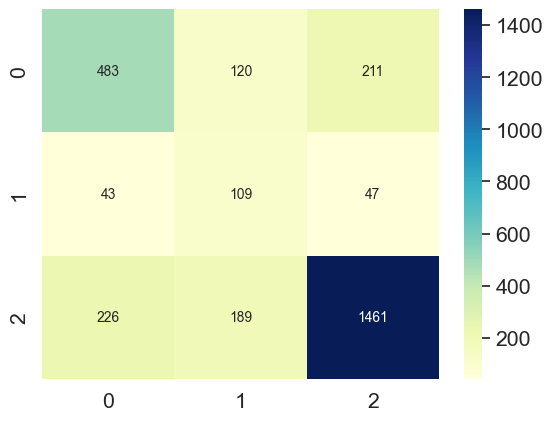

[1:END] Validation loss improved, saved model to ./runs/2/1679770031.590896_BERTGRUSentiment_weighted_not_frozen/model_1.pth


  0%|          | 0/330 [00:00<?, ?it/s]

[2:40] Loss: 0.706
[2:80] Loss: 0.624
[2:120] Loss: 0.598
[2:160] Loss: 0.610
[2:200] Loss: 0.573
[2:240] Loss: 0.648
[2:280] Loss: 0.493
[2:320] Loss: 0.518
[2:END] Took 265.380s
[2:END] Training Loss: 0.595


  0%|          | 0/91 [00:00<?, ?it/s]

[2:END] Validation Loss: 0.879
[2:END] Validation Accuracy: 76.636%
              precision    recall  f1-score   support

           0       0.70      0.60      0.64       814
           1       0.38      0.43      0.40       199
           2       0.83      0.87      0.85      1876

    accuracy                           0.77      2889
   macro avg       0.64      0.63      0.63      2889
weighted avg       0.76      0.77      0.76      2889



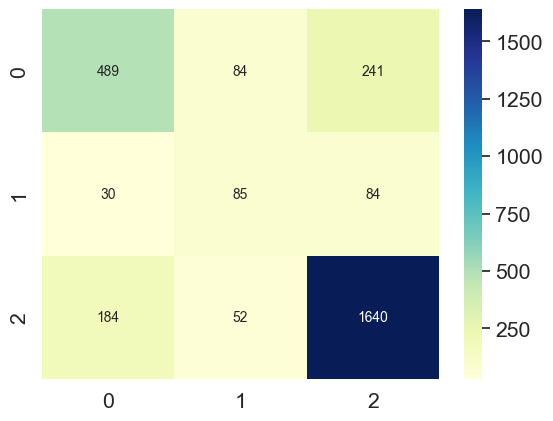

  0%|          | 0/330 [00:00<?, ?it/s]

[3:40] Loss: 0.473
[3:80] Loss: 0.388
[3:120] Loss: 0.449
[3:160] Loss: 0.454
[3:200] Loss: 0.412
[3:240] Loss: 0.339
[3:280] Loss: 0.446
[3:320] Loss: 0.373
[3:END] Took 265.471s
[3:END] Training Loss: 0.416


  0%|          | 0/91 [00:00<?, ?it/s]

[3:END] Validation Loss: 0.837
[3:END] Validation Accuracy: 76.393%
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       814
           1       0.35      0.59      0.44       199
           2       0.89      0.81      0.85      1876

    accuracy                           0.76      2889
   macro avg       0.64      0.70      0.66      2889
weighted avg       0.79      0.76      0.77      2889



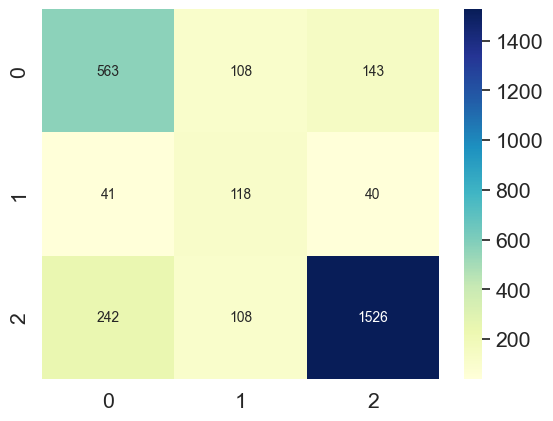

  0%|          | 0/330 [00:00<?, ?it/s]

[4:40] Loss: 0.333
[4:80] Loss: 0.347
[4:120] Loss: 0.386
[4:160] Loss: 0.281
[4:200] Loss: 0.329
[4:240] Loss: 0.311
[4:280] Loss: 0.258
[4:320] Loss: 0.334
[4:END] Took 265.434s
[4:END] Training Loss: 0.322


  0%|          | 0/91 [00:00<?, ?it/s]

[4:END] Validation Loss: 0.868
[4:END] Validation Accuracy: 77.259%
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       814
           1       0.41      0.61      0.49       199
           2       0.90      0.80      0.85      1876

    accuracy                           0.77      2889
   macro avg       0.66      0.72      0.68      2889
weighted avg       0.80      0.77      0.78      2889



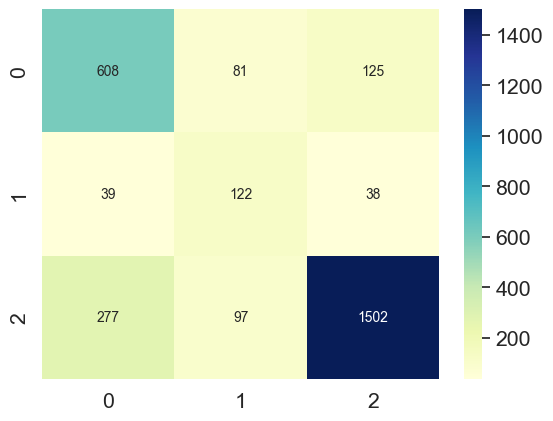

  0%|          | 0/330 [00:00<?, ?it/s]

[5:40] Loss: 0.195
[5:80] Loss: 0.210
[5:120] Loss: 0.169
[5:160] Loss: 0.226
[5:200] Loss: 0.238
[5:240] Loss: 0.300
[5:280] Loss: 0.230
[5:320] Loss: 0.287
[5:END] Took 265.332s
[5:END] Training Loss: 0.230


  0%|          | 0/91 [00:00<?, ?it/s]

[5:END] Validation Loss: 1.285
[5:END] Validation Accuracy: 78.851%
              precision    recall  f1-score   support

           0       0.75      0.60      0.67       814
           1       0.47      0.47      0.47       199
           2       0.83      0.90      0.87      1876

    accuracy                           0.79      2889
   macro avg       0.68      0.66      0.67      2889
weighted avg       0.78      0.79      0.78      2889



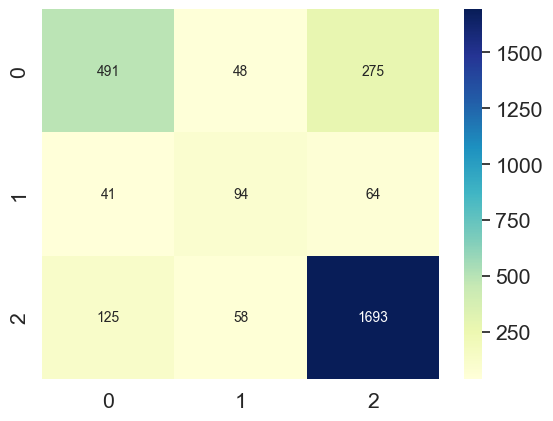

[END] Stopping early as validation loss hasn't improved in 4 epochs
Training complete


In [87]:
best_validation_loss = 1e9
save_path = f"./runs/2/{time.time()}_{model.__class__.__qualname__}_{'weighted' if apply_loss_weighting else 'no_weight'}_{'freeze' if bert_freeze else 'not_frozen'}"
epochs_since_best_validation = 0

os.makedirs(save_path, exist_ok=True)

if not apply_loss_weighting:
    loss_func = nn.CrossEntropyLoss()
else:
    loss_func = nn.CrossEntropyLoss(weight=class_weights.float().to(device))
    
for epoch in range(1, 101):
    model.train()
    epoch_st = time.time()
    epoch_loss = 0
    
    batch_acc_loss = 0
    
    for batch_no, (inp, labels) in enumerate(tqdm(train_dataloader)):
        inp = inp.to(device)
        labels = labels.to(device).squeeze()
        
        # print(inp.shape, labels.shape)

        predictions = model(inp)
        loss = loss_func(predictions, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_loss += loss.item()
        batch_acc_loss += loss.item()

        if batch_no != 0 and batch_no % 40 == 0:
            print(f"[{epoch}:{batch_no}] Loss: {(batch_acc_loss / 40):.3f}")
            batch_acc_loss = 0

    epoch_dt = time.time() - epoch_st
    print(f"[{epoch}:END] Took {epoch_dt:.3f}s")
    print(f"[{epoch}:END] Training Loss: {(epoch_loss / len(train_dataloader)):.3f}")
    
    validation_pred, avg_validation_loss = evaluate_model(model, val_dataloader, val_labels, apply_loss_weighting)
    print(f"[{epoch}:END] Validation Loss: {avg_validation_loss:.3f}")
    print(f"[{epoch}:END] Validation Accuracy: {(validation_pred == val_labels).mean() * 100:.3f}%")
    
    print(metrics.classification_report(val_labels, validation_pred))
    plot_confusion_matrix(val_labels, validation_pred) 
    # plot_roc_curve(val_labels, validation_pred) # meaningless for multi-class
    
    epochs_since_best_validation += 1
    
    if avg_validation_loss < best_validation_loss:
        epochs_since_best_validation = 0
        best_validation_loss = avg_validation_loss
        torch.save(model.state_dict(), f"{save_path}/model_{epoch}.pth")
        print(f"[{epoch}:END] Validation loss improved, saved model to {save_path}/model_{epoch}.pth")
    
    if epochs_since_best_validation >= 4:
        print(f"[END] Stopping early as validation loss hasn't improved in 4 epochs")
        break
        
print("Training complete")

# BERT+MLP

In [73]:
class BERTWithMLPHead(nn.Module):
    def __init__(self, bert, hidden_layers, hidden_dim, output_dim, dropout_prob):
        super().__init__()
        
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        if hidden_layers == 0:
            hidden_dim = [embedding_dim]
        else:
            if type(hidden_dim) is int:
                hidden_dim = [embedding_dim] + [hidden_dim] * hidden_layers
            else:
                hidden_dim = [embedding_dim] + hidden_dim
            
        print(hidden_dim)
        
        layers = []
        
        for i in range(hidden_layers):
            layers += [
                nn.Linear(hidden_dim[i], hidden_dim[i + 1]),
                nn.Dropout(dropout_prob)
            ]
        
        layers.append(nn.Linear(hidden_dim[-1], output_dim))
        
        self.head = nn.Sequential(*layers)
        
    def forward(self, batch):
        with torch.no_grad():
            bert_embeddings = self.bert(batch)[0][:, 0, :]
        
        output = self.head(bert_embeddings)
        return output

In [74]:
mlp_config = {
    "hidden_layers": 1,
    "hidden_dim": 256,
    "output_dim": 3,
    "dropout_prob": 0.2
}

bert_freeze = False

model = BERTWithMLPHead(
    bert=bert,
    **mlp_config
)

[768, 256]


In [75]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = not bert_freeze

In [76]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [77]:
opt = optim.Adam(model.parameters())
model = model.to(device)

In [78]:
def evaluate_model(model, dataloader, labels, apply_loss_weighting):
    if not apply_loss_weighting:
        loss_func = nn.CrossEntropyLoss()
    else:
        loss_func = nn.CrossEntropyLoss(weight=class_weights.float().to(device))
    
    with torch.no_grad():
        model.eval()
        
        all_pred = np.array([])
        total_loss = 0
        
        for inp, labels in tqdm(dataloader):
            inp = inp.to(device)
            labels = labels.to(device).squeeze()
        
            pred = model(inp)
            loss = loss_func(pred, labels)
            _, pred = torch.max(pred.data, 1)
            
            all_pred = np.concatenate([all_pred, pred.cpu().numpy().squeeze()])
            total_loss += loss.item()
        
        model.train()
    
    return all_pred, total_loss / len(dataloader)

  0%|          | 0/330 [00:00<?, ?it/s]

[1:40] Loss: 1.144
[1:80] Loss: 1.115
[1:120] Loss: 1.004
[1:160] Loss: 1.025
[1:200] Loss: 0.998
[1:240] Loss: 0.987
[1:280] Loss: 1.003
[1:320] Loss: 0.940
[1:END] Took 234.906s
[1:END] Training Loss: 1.024


  0%|          | 0/91 [00:00<?, ?it/s]

[1:END] Validation Loss: 1.069
[1:END] Validation Accuracy: 54.725%
              precision    recall  f1-score   support

           0       0.46      0.48      0.47       814
           1       0.12      0.38      0.19       199
           2       0.78      0.59      0.67      1876

    accuracy                           0.55      2889
   macro avg       0.45      0.48      0.44      2889
weighted avg       0.64      0.55      0.58      2889



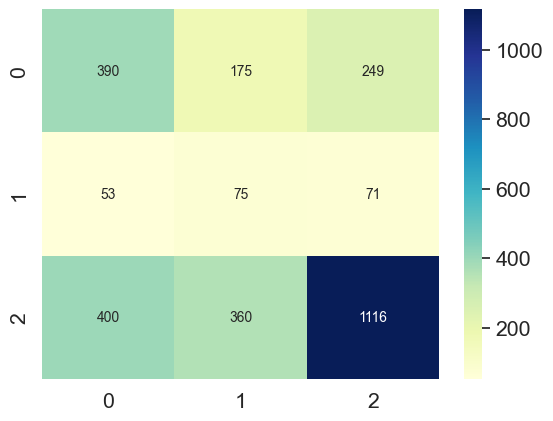

[1:END] Validation loss improved, saved model to ./runs/2/1679767669.2169046_BERTWithMLPHead_weighted_not_frozen/model_1.pth


  0%|          | 0/330 [00:00<?, ?it/s]

[2:40] Loss: 0.956
[2:80] Loss: 0.966
[2:120] Loss: 0.944
[2:160] Loss: 0.966
[2:200] Loss: 0.930
[2:240] Loss: 0.931
[2:280] Loss: 0.969
[2:320] Loss: 0.914
[2:END] Took 233.973s
[2:END] Training Loss: 0.948


  0%|          | 0/91 [00:00<?, ?it/s]

[2:END] Validation Loss: 1.091
[2:END] Validation Accuracy: 60.021%
              precision    recall  f1-score   support

           0       0.49      0.54      0.51       814
           1       0.13      0.22      0.16       199
           2       0.75      0.67      0.71      1876

    accuracy                           0.60      2889
   macro avg       0.46      0.47      0.46      2889
weighted avg       0.64      0.60      0.62      2889



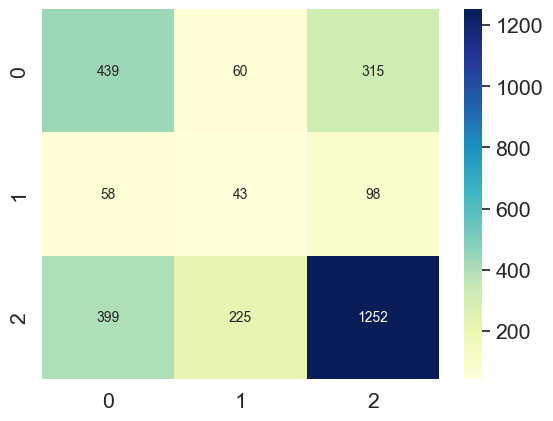

  0%|          | 0/330 [00:00<?, ?it/s]

[3:40] Loss: 0.928
[3:80] Loss: 0.942
[3:120] Loss: 0.946
[3:160] Loss: 0.925
[3:200] Loss: 0.921
[3:240] Loss: 0.915
[3:280] Loss: 0.945
[3:320] Loss: 0.937
[3:END] Took 236.363s
[3:END] Training Loss: 0.933


  0%|          | 0/91 [00:00<?, ?it/s]

[3:END] Validation Loss: 1.007
[3:END] Validation Accuracy: 60.678%
              precision    recall  f1-score   support

           0       0.46      0.58      0.52       814
           1       0.16      0.23      0.19       199
           2       0.78      0.66      0.71      1876

    accuracy                           0.61      2889
   macro avg       0.47      0.49      0.47      2889
weighted avg       0.65      0.61      0.62      2889



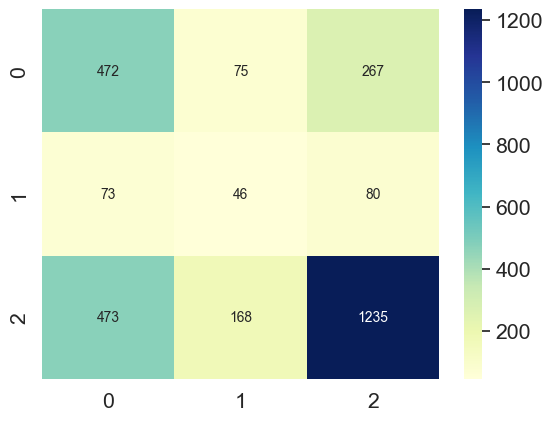

[3:END] Validation loss improved, saved model to ./runs/2/1679767669.2169046_BERTWithMLPHead_weighted_not_frozen/model_3.pth


  0%|          | 0/330 [00:00<?, ?it/s]

[4:40] Loss: 0.933
[4:80] Loss: 0.926
[4:120] Loss: 0.893
[4:160] Loss: 0.973
[4:200] Loss: 0.926
[4:240] Loss: 0.918
[4:280] Loss: 0.910
[4:320] Loss: 0.881
[4:END] Took 241.590s
[4:END] Training Loss: 0.917


  0%|          | 0/91 [00:00<?, ?it/s]

[4:END] Validation Loss: 1.057
[4:END] Validation Accuracy: 54.309%
              precision    recall  f1-score   support

           0       0.50      0.33      0.40       814
           1       0.12      0.50      0.20       199
           2       0.77      0.64      0.70      1876

    accuracy                           0.54      2889
   macro avg       0.46      0.49      0.43      2889
weighted avg       0.65      0.54      0.58      2889



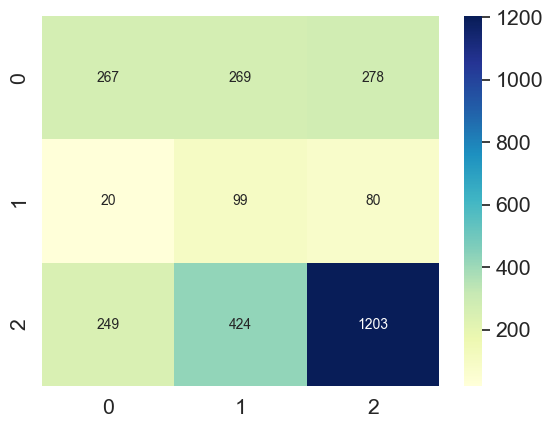

  0%|          | 0/330 [00:00<?, ?it/s]

[5:40] Loss: 0.937
[5:80] Loss: 0.874
[5:120] Loss: 0.925
[5:160] Loss: 0.899
[5:200] Loss: 0.877
[5:240] Loss: 0.874
[5:280] Loss: 0.909
[5:320] Loss: 0.961
[5:END] Took 233.795s
[5:END] Training Loss: 0.904


  0%|          | 0/91 [00:00<?, ?it/s]

[5:END] Validation Loss: 1.107
[5:END] Validation Accuracy: 41.329%
              precision    recall  f1-score   support

           0       0.42      0.36      0.39       814
           1       0.11      0.69      0.19       199
           2       0.83      0.41      0.55      1876

    accuracy                           0.41      2889
   macro avg       0.45      0.49      0.37      2889
weighted avg       0.67      0.41      0.48      2889



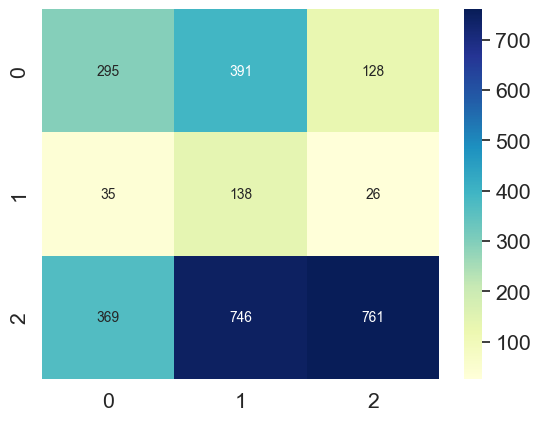

  0%|          | 0/330 [00:00<?, ?it/s]

[6:40] Loss: 0.898
[6:80] Loss: 0.891
[6:120] Loss: 0.837
[6:160] Loss: 0.845
[6:200] Loss: 0.915
[6:240] Loss: 0.937
[6:280] Loss: 0.869
[6:320] Loss: 0.903
[6:END] Took 234.047s
[6:END] Training Loss: 0.885


  0%|          | 0/91 [00:00<?, ?it/s]

[6:END] Validation Loss: 1.044
[6:END] Validation Accuracy: 61.198%
              precision    recall  f1-score   support

           0       0.52      0.35      0.42       814
           1       0.14      0.31      0.19       199
           2       0.75      0.76      0.76      1876

    accuracy                           0.61      2889
   macro avg       0.47      0.47      0.45      2889
weighted avg       0.65      0.61      0.62      2889



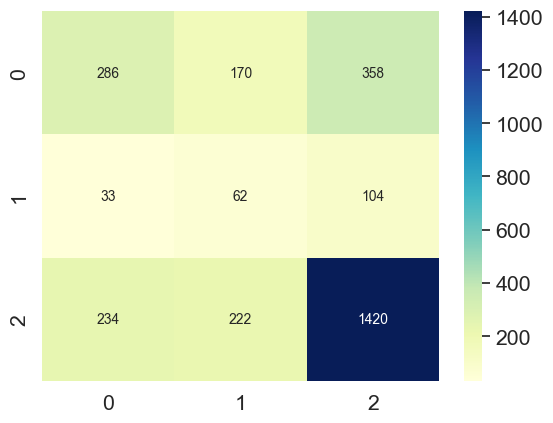

  0%|          | 0/330 [00:00<?, ?it/s]

[7:40] Loss: 0.914
[7:80] Loss: 0.931
[7:120] Loss: 0.841
[7:160] Loss: 0.946
[7:200] Loss: 0.922
[7:240] Loss: 0.889
[7:280] Loss: 0.846
[7:320] Loss: 0.878
[7:END] Took 239.919s
[7:END] Training Loss: 0.895


  0%|          | 0/91 [00:00<?, ?it/s]

[7:END] Validation Loss: 1.066
[7:END] Validation Accuracy: 59.709%
              precision    recall  f1-score   support

           0       0.51      0.48      0.50       814
           1       0.12      0.24      0.16       199
           2       0.74      0.68      0.71      1876

    accuracy                           0.60      2889
   macro avg       0.46      0.47      0.46      2889
weighted avg       0.64      0.60      0.61      2889



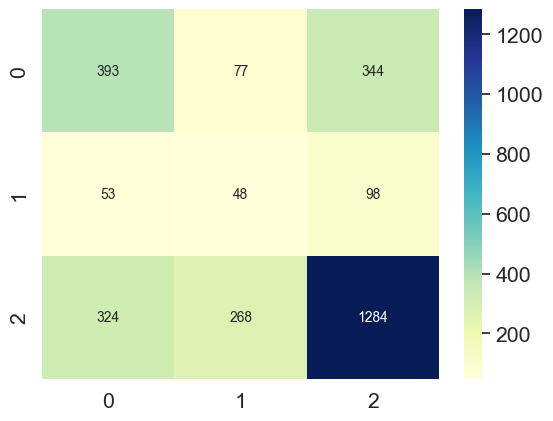

[END] Stopping early as validation loss hasn't improved in 4 epochs
Training complete


In [79]:
best_validation_loss = 1e9
save_path = f"./runs/2/{time.time()}_{model.__class__.__qualname__}_{'weighted' if apply_loss_weighting else 'no_weight'}_{'freeze' if bert_freeze else 'not_frozen'}"
epochs_since_best_validation = 0

os.makedirs(save_path, exist_ok=True)

if not apply_loss_weighting:
    loss_func = nn.CrossEntropyLoss()
else:
    loss_func = nn.CrossEntropyLoss(weight=class_weights.float().to(device))
    
for epoch in range(1, 101):
    model.train()
    epoch_st = time.time()
    epoch_loss = 0
    
    batch_acc_loss = 0
    
    for batch_no, (inp, labels) in enumerate(tqdm(train_dataloader)):
        inp = inp.to(device)
        labels = labels.to(device).squeeze()
        
        # print(inp.shape, labels.shape)

        predictions = model(inp)
        # print(predictions.shape, labels.shape)
        loss = loss_func(predictions, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_loss += loss.item()
        batch_acc_loss += loss.item()

        if batch_no != 0 and batch_no % 40 == 0:
            print(f"[{epoch}:{batch_no}] Loss: {(batch_acc_loss / 40):.3f}")
            batch_acc_loss = 0

    epoch_dt = time.time() - epoch_st
    print(f"[{epoch}:END] Took {epoch_dt:.3f}s")
    print(f"[{epoch}:END] Training Loss: {(epoch_loss / len(train_dataloader)):.3f}")
    
    validation_pred, avg_validation_loss = evaluate_model(model, val_dataloader, val_labels, apply_loss_weighting)
    print(f"[{epoch}:END] Validation Loss: {avg_validation_loss:.3f}")
    print(f"[{epoch}:END] Validation Accuracy: {(validation_pred == val_labels).mean() * 100:.3f}%")
    
    print(metrics.classification_report(val_labels, validation_pred))
    plot_confusion_matrix(val_labels, validation_pred) 
    # plot_roc_curve(val_labels, validation_pred) # meaningless for multi-class
    
    epochs_since_best_validation += 1
    
    if avg_validation_loss < best_validation_loss:
        epochs_since_best_validation = 0
        best_validation_loss = avg_validation_loss
        torch.save(model.state_dict(), f"{save_path}/model_{epoch}.pth")
        print(f"[{epoch}:END] Validation loss improved, saved model to {save_path}/model_{epoch}.pth")
    
    if epochs_since_best_validation >= 4:
        print(f"[END] Stopping early as validation loss hasn't improved in 4 epochs")
        break
        
print("Training complete")

# BERT+CNN

In [203]:
class BERTWithCNN(nn.Module):
    def __init__(self, bert):
        super().__init__()
        
        self.bert = bert
        embedding_dim = bert.config.to_dict()["hidden_size"]
        
        # self.layers = nn.Sequential(
        #     # nn.Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1)),
        #     # nn.ReLU(),
        #     # nn.Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1)),
        #     # nn.ReLU(),
        #     # nn.Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1)),
        #     # nn.ReLU(),
        #     # nn.Conv1d(in_channels=768, out_channels=384, kernel_size=5, padding="valid", stride=1),
        #     # nn.ReLU(),
        #     # nn.MaxPool1d(kernel_size= 64- 5 + 1),
        #     # nn.Dropout(0.2),
        #     # nn.Linear(384, 192),
        #     # nn.Linear(192, 3)
        # )
        
        # self.lstm = nn.LSTM(
        
        self.first_conv = nn.Sequential(
            nn.Conv1d(768, 512, 5, padding=2),
            nn.ReLU(),
            # nn.MaxPool1d(256 + 1)
        )
        
        self.second_conv = nn.Sequential(
            nn.Conv1d(512, 256, 5, padding=2),
            nn.ReLU(),
            # nn.MaxPool1d(256 + 1)
        )
        
        self.rnn = nn.GRU(256,
                          256,
                          num_layers = 2,
                          bidirectional = True,
                          batch_first = True,
                          dropout = 0.2)
        
        self.out = nn.Linear(256 * 2, 3)
        
        self.dropout = nn.Dropout(0.2)
        
        # self.conv = nn.Conv1d(768, 384, 5, padding=2)
    
    def forward(self, batch):
        with torch.no_grad():
            embedded = self.bert(batch)[0]
        
        # (b, 512, 768)
        # print("BERT Embeddings (N, L, C)", embedded.shape)
        
        embedded = embedded.permute(0, 2, 1)
        # print("Rearranged to (N, C, L)", embedded.shape)
        
        x = self.first_conv(embedded)
        # print("After Conv", x.shape)
        
        x = self.second_conv(x)
        # print("After Conv 2", x.shape)
        
        x = x.permute(0, 2, 1)
        # print("Rearranged to (N, L, C)", embedded.shape)
        
        
        _, hidden = self.rnn(x)
    
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        
        output = self.out(hidden)        
        
        return output
        
        # processed = processed.permute(0, 2, 1)
        # print(processed.shape)
        # embedded = embedded.permute(0, 2, 1)
        
        #x = self.layers(embedded)
        #print(x.shape)
        

In [204]:
model = BERTWithCNN(bert)
bert_freeze = True

In [205]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = not bert_freeze

In [206]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

first_conv.0.weight
first_conv.0.bias
second_conv.0.weight
second_conv.0.bias
rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out.weight
out.bias


In [207]:
model = model.to(device)

In [208]:
opt = optim.Adam(model.parameters())

In [209]:
def evaluate_model(model, dataloader, labels, apply_loss_weighting):
    if not apply_loss_weighting:
        loss_func = nn.CrossEntropyLoss()
    else:
        loss_func = nn.CrossEntropyLoss(weight=class_weights.float().to(device))
    
    with torch.no_grad():
        model.eval()
        
        all_pred = np.array([])
        total_loss = 0
        
        for inp, labels in tqdm(dataloader):
            inp = inp.to(device)
            labels = labels.to(device).squeeze()
        
            pred = model(inp)
            loss = loss_func(pred, labels)
            _, pred = torch.max(pred.data, 1)
            
            all_pred = np.concatenate([all_pred, pred.cpu().numpy().squeeze()])
            total_loss += loss.item()
        
        model.train()
    
    return all_pred, total_loss / len(dataloader)

  0%|          | 0/337 [00:00<?, ?it/s]

[1:40] Loss: 1.163
[1:80] Loss: 0.949
[1:120] Loss: 0.936
[1:160] Loss: 0.962
[1:200] Loss: 0.936
[1:240] Loss: 0.909
[1:280] Loss: 0.902
[1:320] Loss: 0.862
[1:END] Took 277.084s
[1:END] Training Loss: 0.943


  0%|          | 0/84 [00:00<?, ?it/s]

[1:END] Validation Loss: 0.913
[1:END] Validation Accuracy: 69.049%
              precision    recall  f1-score   support

           0       0.52      0.69      0.59       731
           1       0.29      0.27      0.28       203
           2       0.85      0.74      0.79      1738

    accuracy                           0.69      2672
   macro avg       0.55      0.57      0.55      2672
weighted avg       0.72      0.69      0.70      2672



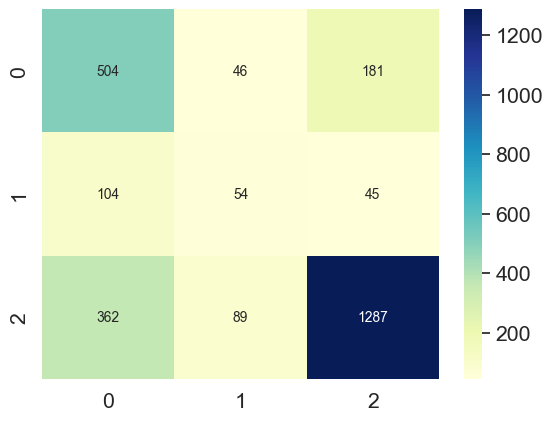

[1:END] Validation loss improved, saved model to ./runs/2/1680284211.3691754_BERTWithCNN_weighted_freeze/model_1.pth


  0%|          | 0/337 [00:00<?, ?it/s]

[2:40] Loss: 0.819
[2:80] Loss: 0.776
[2:120] Loss: 0.750
[2:160] Loss: 0.738
[2:200] Loss: 0.706
[2:240] Loss: 0.684
[2:280] Loss: 0.734
[2:320] Loss: 0.721
[2:END] Took 276.570s
[2:END] Training Loss: 0.742


  0%|          | 0/84 [00:00<?, ?it/s]

[2:END] Validation Loss: 0.880
[2:END] Validation Accuracy: 69.311%
              precision    recall  f1-score   support

           0       0.52      0.71      0.60       731
           1       0.33      0.17      0.22       203
           2       0.82      0.75      0.78      1738

    accuracy                           0.69      2672
   macro avg       0.56      0.54      0.54      2672
weighted avg       0.70      0.69      0.69      2672



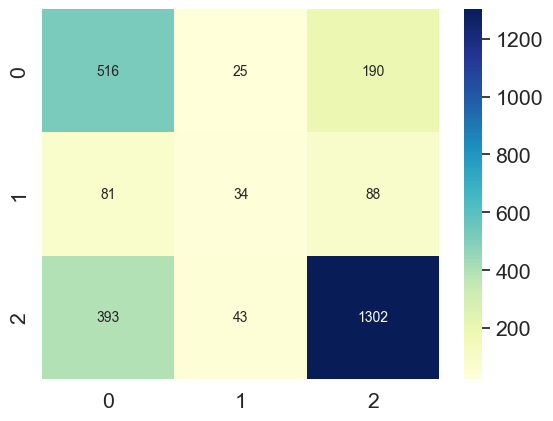

[2:END] Validation loss improved, saved model to ./runs/2/1680284211.3691754_BERTWithCNN_weighted_freeze/model_2.pth


  0%|          | 0/337 [00:00<?, ?it/s]

[3:40] Loss: 0.647
[3:80] Loss: 0.678
[3:120] Loss: 0.636
[3:160] Loss: 0.542
[3:200] Loss: 0.735
[3:240] Loss: 0.560
[3:280] Loss: 0.599
[3:320] Loss: 0.581
[3:END] Took 276.542s
[3:END] Training Loss: 0.615


  0%|          | 0/84 [00:00<?, ?it/s]

[3:END] Validation Loss: 0.858
[3:END] Validation Accuracy: 67.403%
              precision    recall  f1-score   support

           0       0.52      0.68      0.59       731
           1       0.27      0.46      0.34       203
           2       0.89      0.70      0.78      1738

    accuracy                           0.67      2672
   macro avg       0.56      0.61      0.57      2672
weighted avg       0.74      0.67      0.69      2672



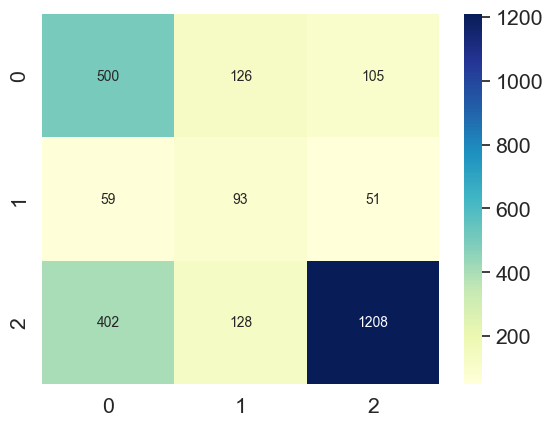

[3:END] Validation loss improved, saved model to ./runs/2/1680284211.3691754_BERTWithCNN_weighted_freeze/model_3.pth


  0%|          | 0/337 [00:00<?, ?it/s]

[4:40] Loss: 0.524
[4:80] Loss: 0.574
[4:120] Loss: 0.525
[4:160] Loss: 0.544
[4:200] Loss: 0.531
[4:240] Loss: 0.515
[4:280] Loss: 0.610
[4:320] Loss: 0.548
[4:END] Took 277.074s
[4:END] Training Loss: 0.545


  0%|          | 0/84 [00:00<?, ?it/s]

[4:END] Validation Loss: 0.878
[4:END] Validation Accuracy: 70.397%
              precision    recall  f1-score   support

           0       0.62      0.57      0.59       731
           1       0.29      0.52      0.38       203
           2       0.83      0.78      0.81      1738

    accuracy                           0.70      2672
   macro avg       0.58      0.62      0.59      2672
weighted avg       0.73      0.70      0.71      2672



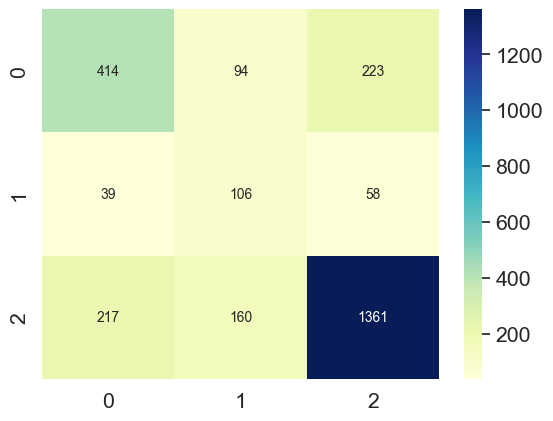

  0%|          | 0/337 [00:00<?, ?it/s]

[5:40] Loss: 0.472
[5:80] Loss: 0.476
[5:120] Loss: 0.387
[5:160] Loss: 0.430
[5:200] Loss: 0.541
[5:240] Loss: 0.455
[5:280] Loss: 0.482
[5:320] Loss: 0.456
[5:END] Took 276.700s
[5:END] Training Loss: 0.462


  0%|          | 0/84 [00:00<?, ?it/s]

[5:END] Validation Loss: 0.926
[5:END] Validation Accuracy: 71.557%
              precision    recall  f1-score   support

           0       0.62      0.57      0.60       731
           1       0.30      0.52      0.38       203
           2       0.84      0.80      0.82      1738

    accuracy                           0.72      2672
   macro avg       0.59      0.63      0.60      2672
weighted avg       0.74      0.72      0.73      2672



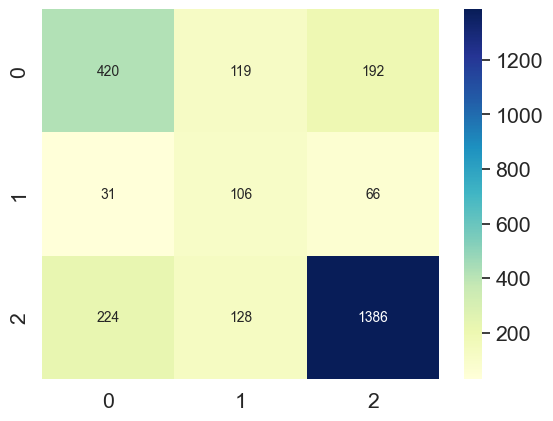

  0%|          | 0/337 [00:00<?, ?it/s]

[6:40] Loss: 0.360
[6:80] Loss: 0.342
[6:120] Loss: 0.361
[6:160] Loss: 0.394
[6:200] Loss: 0.403
[6:240] Loss: 0.318
[6:280] Loss: 0.352
[6:320] Loss: 0.393
[6:END] Took 278.234s
[6:END] Training Loss: 0.364


  0%|          | 0/84 [00:00<?, ?it/s]

[6:END] Validation Loss: 1.031
[6:END] Validation Accuracy: 63.772%
              precision    recall  f1-score   support

           0       0.47      0.78      0.59       731
           1       0.33      0.61      0.43       203
           2       0.93      0.58      0.71      1738

    accuracy                           0.64      2672
   macro avg       0.58      0.66      0.58      2672
weighted avg       0.76      0.64      0.66      2672



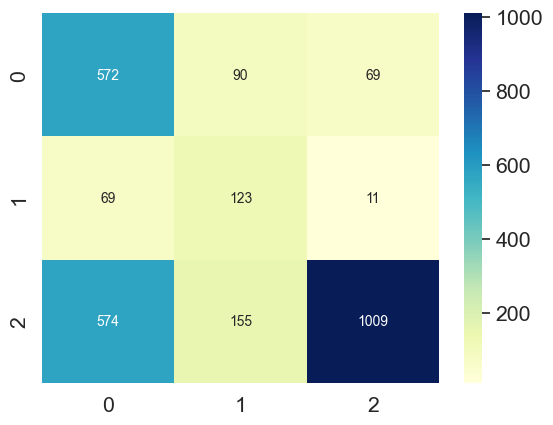

  0%|          | 0/337 [00:00<?, ?it/s]

[7:40] Loss: 0.320
[7:80] Loss: 0.331
[7:120] Loss: 0.378
[7:160] Loss: 0.328
[7:200] Loss: 0.266
[7:240] Loss: 0.329
[7:280] Loss: 0.322
[7:320] Loss: 0.306
[7:END] Took 277.754s
[7:END] Training Loss: 0.321


  0%|          | 0/84 [00:00<?, ?it/s]

[7:END] Validation Loss: 1.036
[7:END] Validation Accuracy: 73.091%
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       731
           1       0.35      0.42      0.38       203
           2       0.84      0.82      0.83      1738

    accuracy                           0.73      2672
   macro avg       0.60      0.62      0.61      2672
weighted avg       0.74      0.73      0.73      2672



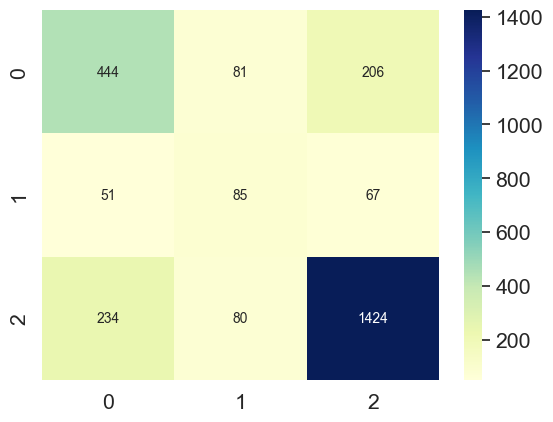

[END] Stopping early as validation loss hasn't improved in 4 epochs
Training complete


In [210]:
best_validation_loss = 1e9
save_path = f"./runs/2/{time.time()}_{model.__class__.__qualname__}_{'weighted' if apply_loss_weighting else 'no_weight'}_{'freeze' if bert_freeze else 'not_frozen'}"
epochs_since_best_validation = 0

os.makedirs(save_path, exist_ok=True)

if not apply_loss_weighting:
    loss_func = nn.CrossEntropyLoss()
else:
    loss_func = nn.CrossEntropyLoss(weight=class_weights.float().to(device))
    
for epoch in range(1, 101):
    model.train()
    epoch_st = time.time()
    epoch_loss = 0
    
    batch_acc_loss = 0
    
    for batch_no, (inp, labels) in enumerate(tqdm(train_dataloader)):
        inp = inp.to(device)
        labels = labels.to(device).squeeze()
        
        # print(inp.shape, labels.shape)

        predictions = model(inp)
        loss = loss_func(predictions, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_loss += loss.item()
        batch_acc_loss += loss.item()

        if batch_no != 0 and batch_no % 40 == 0:
            print(f"[{epoch}:{batch_no}] Loss: {(batch_acc_loss / 40):.3f}")
            batch_acc_loss = 0

    epoch_dt = time.time() - epoch_st
    print(f"[{epoch}:END] Took {epoch_dt:.3f}s")
    print(f"[{epoch}:END] Training Loss: {(epoch_loss / len(train_dataloader)):.3f}")
    
    validation_pred, avg_validation_loss = evaluate_model(model, val_dataloader, val_labels, apply_loss_weighting)
    print(f"[{epoch}:END] Validation Loss: {avg_validation_loss:.3f}")
    print(f"[{epoch}:END] Validation Accuracy: {(validation_pred == val_labels).mean() * 100:.3f}%")
    
    print(metrics.classification_report(val_labels, validation_pred))
    plot_confusion_matrix(val_labels, validation_pred) 
    # plot_roc_curve(val_labels, validation_pred) # meaningless for multi-class
    
    epochs_since_best_validation += 1
    
    if avg_validation_loss < best_validation_loss:
        epochs_since_best_validation = 0
        best_validation_loss = avg_validation_loss
        torch.save(model.state_dict(), f"{save_path}/model_{epoch}.pth")
        print(f"[{epoch}:END] Validation loss improved, saved model to {save_path}/model_{epoch}.pth")
    
    if epochs_since_best_validation >= 4:
        print(f"[END] Stopping early as validation loss hasn't improved in 4 epochs")
        break
        
print("Training complete")

# BERT Finetune

In [98]:
from transformers import BertForSequenceClassification

label2id = {
    "agree": 0,
    "disagree": 1,
    "discuss": 2
}

id2label = {
    0: "agree",
    1: "disagree",
    2: "discuss"
}

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                    problem_type="single_label_classification", 
                                                    num_labels=len(label2id.keys()),
                                                    id2label=id2label,
                                                    label2id=label2id)

model = model.to(device)

loading configuration file config.json from cache at C:\Users\yoyo1/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "agree",
    "1": "disagree",
    "2": "discuss"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "agree": 0,
    "disagree": 1,
    "discuss": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

RuntimeError: CUDA out of memory. Tried to allocate 90.00 MiB (GPU 0; 8.00 GiB total capacity; 7.31 GiB already allocated; 0 bytes free; 7.35 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [95]:
from transformers import AdamW

In [96]:
optim = AdamW(model.parameters(), lr=5e-5)

AttributeError: 'NoneType' object has no attribute 'parameters'

In [93]:
for epoch in range(10):
    for batch_no, (inp, labels) in enumerate(tqdm(train_dataloader)):
        inp = inp.to(device)
        labels = labels.to(device).squeeze()
        outputs = model(inp, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        
model.eval()

  0%|          | 0/1360 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 8.00 GiB total capacity; 7.24 GiB already allocated; 0 bytes free; 7.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [101]:
import gc

model = None
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()